## Explore Overfitting and Underfitting

We'll explore two common regularization techniques—weight regularization and dropout—and

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dropout

In [7]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load  dataset

dataset = pd.read_csv('/home/francovm/Projects/SSE/data/processed/input_data.csv', sep='\t', encoding='utf-8' ,index_col=0)


X_data = dataset.drop(columns=['Events'])

#one-hot encode target column
Y_data = dataset['Events'].values


#get number of columns in training data
n_cols = X_data.shape[1]



In [8]:
# split into 67% for train and 33% for test
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.4, random_state=seed)

# Baseline Model

In [9]:
baseline_model = Sequential()

#add layers to model
baseline_model.add(Dense(16, activation='relu', input_shape=(n_cols,)))
baseline_model.add(Dense(16, activation='relu'))
baseline_model.add(Dense(1, activation='sigmoid'))

baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy','binary_crossentropy'])
baseline_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                96        
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


In [10]:

#set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=5)

# Fit the model

baseline_history = baseline_model.fit(X_train,y_train, 
                      epochs=20, 
                      validation_split=0.4,
                      batch_size=64,
                      callbacks=[early_stopping_monitor],
                      verbose=1)

Train on 82483 samples, validate on 54990 samples
Epoch 1/20
82483/82483 [==============================] - 5s 56us/step - loss: nan - acc: 1.3336e-04 - binary_crossentropy: nan - val_loss: nan - val_acc: 0.0000e+00 - val_binary_crossentropy: nan
Epoch 2/20
58880/82483 [====================>.........] - ETA: 1s - loss: nan - acc: 0.0000e+00 - binary_crossentropy: nan

KeyboardInterrupt: 

In [39]:
smaller_model = Sequential()

#add layers to model
smaller_model.add(Dense(4, activation='relu', input_shape=(n_cols,)))
smaller_model.add(Dense(4, activation='relu'))
smaller_model.add(Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

smaller_model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 4)                 28        
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 5         
Total params: 53
Trainable params: 53
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Fit the model

smaller_history = smaller_model.fit(X_train,y_train, 
                      epochs=20, 
                      validation_split=0.4,
                      batch_size=64,
                      callbacks=[early_stopping_monitor],
                      verbose=1)

Train on 81978 samples, validate on 54652 samples
Epoch 1/20
81978/81978 [==============================] - 7s 80us/step - loss: 1.8980 - acc: 0.7757 - binary_crossentropy: 1.8980 - val_loss: 0.3511 - val_acc: 0.9573 - val_binary_crossentropy: 0.3511
Epoch 2/20
81978/81978 [==============================] - 5s 63us/step - loss: 0.2861 - acc: 0.9552 - binary_crossentropy: 0.2861 - val_loss: 0.2333 - val_acc: 0.9580 - val_binary_crossentropy: 0.2333
Epoch 3/20
81978/81978 [==============================] - 5s 63us/step - loss: 0.2142 - acc: 0.9554 - binary_crossentropy: 0.2142 - val_loss: 0.1915 - val_acc: 0.9580 - val_binary_crossentropy: 0.1915
Epoch 4/20
81978/81978 [==============================] - 5s 61us/step - loss: 0.1900 - acc: 0.9554 - binary_crossentropy: 0.1900 - val_loss: 0.1777 - val_acc: 0.9581 - val_binary_crossentropy: 0.1777
Epoch 5/20
81978/81978 [==============================] - 5s 65us/step - loss: 0.1833 - acc: 0.9554 - binary_crossentropy: 0.1833 - val_loss: 0.17

In [47]:

bigger_model = Sequential()

#add layers to model
bigger_model.add(Dense(512, activation='relu', input_shape=(n_cols,)))
bigger_model.add(Dense(512,activation='relu'))
bigger_model.add(Dense(1, activation='sigmoid'))

bigger_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

bigger_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 512)               3584      
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 513       
Total params: 266,753
Trainable params: 266,753
Non-trainable params: 0
_________________________________________________________________


In [48]:
# Fit the model

bigger_history = bigger_model.fit(X_train,y_train, 
                      epochs=20, 
                      validation_split=0.4,
                      batch_size=64,
                      callbacks=[early_stopping_monitor],
                      verbose=1)

Train on 81978 samples, validate on 54652 samples
Epoch 1/20
81978/81978 [==============================] - 20s 250us/step - loss: 0.2205 - acc: 0.9540 - binary_crossentropy: 0.2205 - val_loss: 0.1729 - val_acc: 0.9581 - val_binary_crossentropy: 0.1729
Epoch 2/20
81978/81978 [==============================] - 19s 235us/step - loss: 0.1808 - acc: 0.9554 - binary_crossentropy: 0.1808 - val_loss: 0.1696 - val_acc: 0.9581 - val_binary_crossentropy: 0.1696
Epoch 3/20
81978/81978 [==============================] - 20s 239us/step - loss: 0.1759 - acc: 0.9554 - binary_crossentropy: 0.1759 - val_loss: 0.1728 - val_acc: 0.9581 - val_binary_crossentropy: 0.1728
Epoch 4/20
81978/81978 [==============================] - 16s 195us/step - loss: 0.1740 - acc: 0.9554 - binary_crossentropy: 0.1740 - val_loss: 0.1681 - val_acc: 0.9581 - val_binary_crossentropy: 0.1681
Epoch 5/20
81978/81978 [==============================] - 18s 220us/step - loss: 0.1721 - acc: 0.9554 - binary_crossentropy: 0.1721 - val_

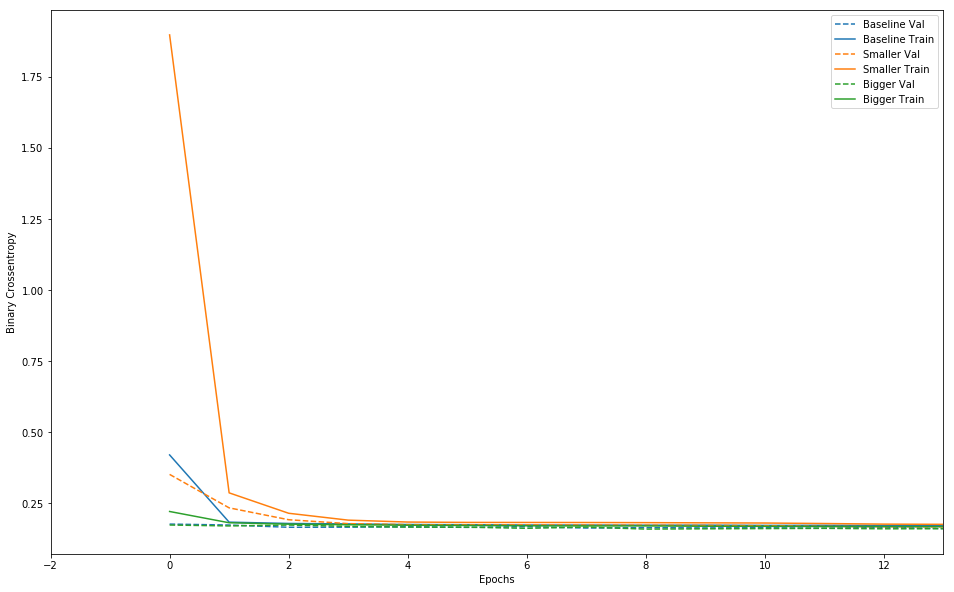

In [51]:
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([-2,max(history.epoch)])


plot_history([('baseline', baseline_history),
              ('smaller', smaller_history),
              ('bigger', bigger_history)])

# Regularization

## *L2*

In [52]:
l2_model = Sequential()

#add layers to model
l2_model.add(Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001),input_shape=(n_cols,)))
l2_model.add(Dense(512,activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
l2_model.add(Dense(1, activation='sigmoid'))

l2_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy','binary_crossentropy'])

l2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 512)               3584      
_________________________________________________________________
dense_29 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 513       
Total params: 266,753
Trainable params: 266,753
Non-trainable params: 0
_________________________________________________________________


In [53]:

# Fit the model

l2_model_history =  l2_model.fit(X_train,y_train, 
                      epochs=20, 
                      validation_split=0.3,
                      batch_size=64,
                      callbacks=[early_stopping_monitor],
                      verbose=1)

Train on 95641 samples, validate on 40989 samples
Epoch 1/20
95641/95641 [==============================] - 12s 122us/step - loss: 0.3914 - acc: 0.9535 - binary_crossentropy: 0.2387 - val_loss: 0.2158 - val_acc: 0.9584 - val_binary_crossentropy: 0.1683
Epoch 2/20
95641/95641 [==============================] - 13s 133us/step - loss: 0.1988 - acc: 0.9557 - binary_crossentropy: 0.1767 - val_loss: 0.1721 - val_acc: 0.9584 - val_binary_crossentropy: 0.1642
Epoch 3/20
95641/95641 [==============================] - 11s 113us/step - loss: 0.1777 - acc: 0.9557 - binary_crossentropy: 0.1737 - val_loss: 0.1684 - val_acc: 0.9584 - val_binary_crossentropy: 0.1664
Epoch 4/20
95641/95641 [==============================] - 11s 112us/step - loss: 0.1743 - acc: 0.9557 - binary_crossentropy: 0.1728 - val_loss: 0.1639 - val_acc: 0.9584 - val_binary_crossentropy: 0.1626
Epoch 5/20
95641/95641 [==============================] - 11s 115us/step - loss: 0.1732 - acc: 0.9557 - binary_crossentropy: 0.1720 - val_

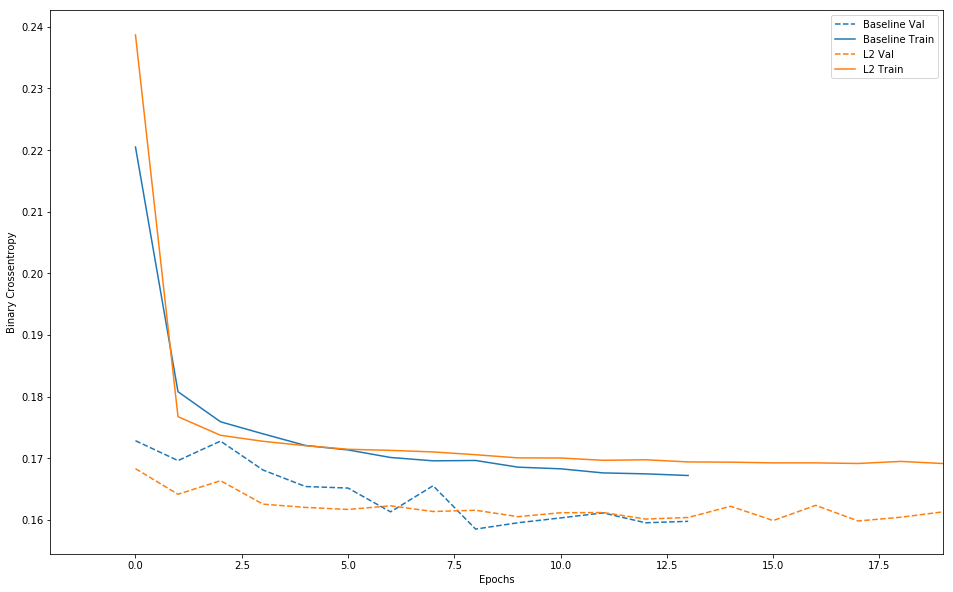

In [54]:
plot_history([('baseline', bigger_history),
              ('l2', l2_model_history)])

## *Dropout*

In [55]:
dpt_model = Sequential()

#add layers to model
dpt_model.add(Dense(512, activation='relu',input_shape=(n_cols,)))
dpt_model.add(Dropout(0.5))
dpt_model.add(Dense(512,activation='relu'))
dpt_model.add(Dropout(0.5))
dpt_model.add(Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

dpt_model.summary()


# Fit the model

dpt_model_history =  dpt_model.fit(X_train,y_train, 
                      epochs=20, 
                      validation_split=0.3,
                      batch_size=64,
                      callbacks=[early_stopping_monitor],
                      verbose=1)

W0823 11:08:40.038837 140559063209792 deprecation.py:506] From /home/francovm/anaconda3/envs/keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 512)               3584      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 513       
Total params: 266,753
Trainable params: 266,753
Non-trainable params: 0
_________________________________________________________________
Train on 95641 samples, validate on 40989 samples
Epoch 1/20
95641/95641 [==============================] - 20s 207us/step - loss: 0.250

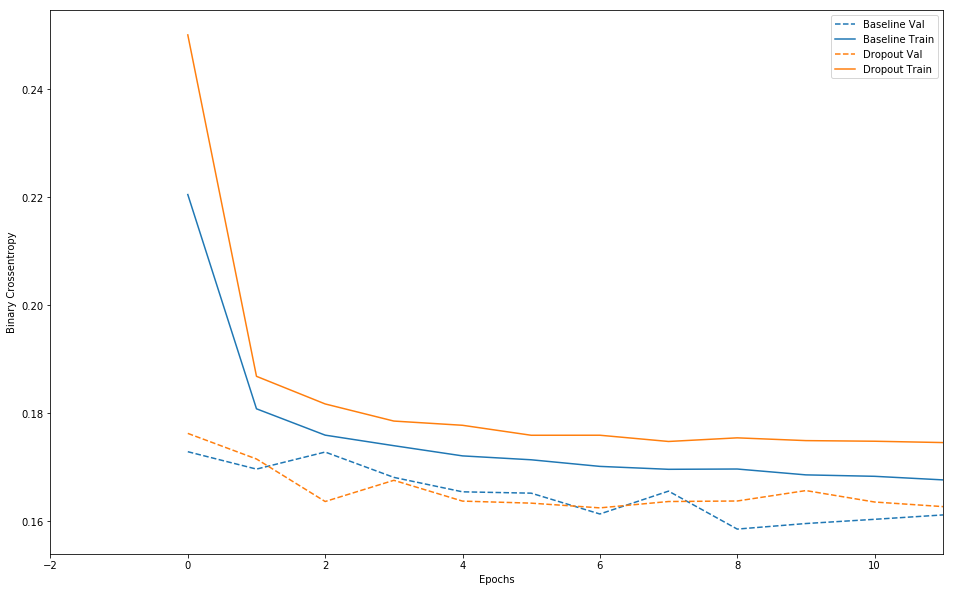

In [57]:
plot_history([('baseline', bigger_history),
              ('dropout', dpt_model_history)])

In [58]:
# evaluate the model
scores = bigger_model.evaluate(X_test,y_test)
print((scores[1]*100))

91087/91087 [==============================] - 4s 40us/step
95.57895199108458


# USE THIS FUNCTION TO FIND BATCH SIZE, JUST EXACTLY BEFORE STARTING YOUR TRAINING/ TESTING.

In [1]:
def FindBatchSize(model):
    """#model: model architecture, that is yet to be trained"""
    import os, sys, psutil, gc, tensorflow, keras
    import numpy as np
    from keras import backend as K
    BatchFound= 16

    try:
        total_params= int(model.count_params());    GCPU= "CPU"
        #find whether gpu is available
        try:
            if K.tensorflow_backend._get_available_gpus()== []:
                GCPU= "CPU";    #CPU and Cuda9GPU
            else:
                GCPU= "GPU"
        except:
            from tensorflow.python.client import device_lib;    #Cuda8GPU
            def get_available_gpus():
                local_device_protos= device_lib.list_local_devices()
                return [x.name for x in local_device_protos if x.device_type == 'GPU']
            if "gpu" not in str(get_available_gpus()).lower():
                GCPU= "CPU"
            else:
                GCPU= "GPU"

        #decide batch size on the basis of GPU availability and model complexity
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params <1000000):
            BatchFound= 64    
        if (os.cpu_count() <16) and (total_params <500000):
            BatchFound= 64  
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params <2000000) and (total_params >=1000000):
            BatchFound= 32      
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params >=2000000) and (total_params <10000000):
            BatchFound= 16  
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params >=10000000):
            BatchFound= 8       
        if (os.cpu_count() <16) and (total_params >5000000):
            BatchFound= 8    
        if total_params >100000000:
            BatchFound= 1

    except:
        pass
    try:

        #find percentage of memory used
        memoryused= psutil.virtual_memory()
        memoryused= float(str(memoryused).replace(" ", "").split("percent=")[1].split(",")[0])
        if memoryused >75.0:
            BatchFound= 8
        if memoryused >85.0:
            BatchFound= 4
        if memoryused >90.0:
            BatchFound= 2
        if total_params >100000000:
            BatchFound= 1
        print("Batch Size:  "+ str(BatchFound));    gc.collect()
    except:
        pass

    memoryused= [];    total_params= [];    GCPU= "";
    del memoryused, total_params, GCPU;    gc.collect()
    return BatchFound



#####################################################################################################
#####################################################################################################

In [2]:
FindBatchSize(bigger_model)

NameError: name 'bigger_model' is not defined